# Main Challenges of Machine Learning

In short, since your main task is to select a learning algorithm and train it on some data, the two things that can go wrong are **"bad algorithm"** and **"bad data"**.

## Insufficient Quantity of Training Data

Machine learning algorithms take a lot of data for most tasks and work properly. Even for very simple problems you typically need thousands of examples, and for complex problems such as image or speech recognition you may need millions of examples (unles you can reuse parts of an existing model).

## Nonrepresentative Training Data

In order to generalize well, it is crucial that your training data be representative of the new cases you want to generalize to. This is true whether you use instance-based learning or model-based learning.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

%matplotlib inline

# common imports
import numpy as np
import os
import warnings
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# to make this notebook's output stable across runs
np.random.seed(42)

# to plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

datapath = os.path.join("datasets", "lifesat", "")

oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace=True)
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

In [2]:
# mostramos el data frame missing_data
missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


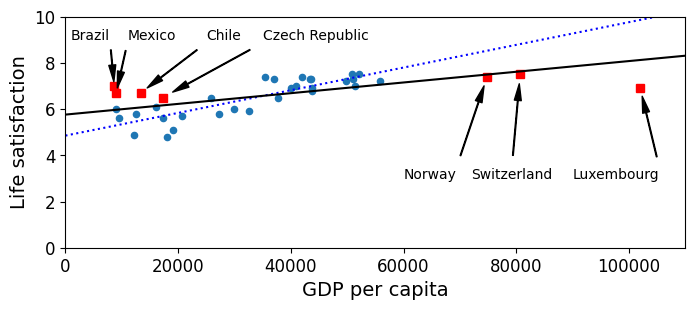

In [3]:
# Se realize lo siguiente:
# 1.- mostrar una gráfica de disperción los datos originales
# 2.-  agregamos los datos faltantes. Los paises: Brazil, Mexico, Chile, Czech Republic, Switzerland, Luxemburg
# 3.- Generamos un  modelo lineal con los datos originales
# 4.- Generamos un modelo con los datos faltantes
# 5.- Mostramos las rectas definidas por los coeficientes de cada modelo.

from sklearn import linear_model
position_text2 = {
    "Brazil":(1000,9.0),
    "Mexico":(11000,9.0),
    "Chile":(25000,9.0),
    "Czech Republic":(35000,9.0),
    "Norway":(60000,3),
    "Switzerland":(72000,3.0),
    "Luxembourg":(90000,3.0),
}
lin1 = linear_model.LinearRegression()
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
lin1.fit(Xsample,ysample)
t0,t1 = lin1.intercept_[0],lin1.coef_[0][0]
t0,t1

sample_data.plot(kind='scatter',x="GDP per capita",y='Life satisfaction',figsize=(8,3))
plt.axis([0,110000,0,10])
for country,pos_text in position_text2.items():
    pos_data_x,pos_data_y = missing_data.loc[country]
    plt.annotate(country,xy=(pos_data_x,pos_data_y),xytext=pos_text,arrowprops=dict(facecolor='black',width=0.5,shrink=0.1,headwidth=5))
    plt.plot(pos_data_x,pos_data_y,"rs")

X=np.linspace(0,110000,1000)
plt.plot(X, t0 + t1 * X,"b:")

lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull,yfull)

t0full, t1full=lin_reg_full.intercept_[0],lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.show()

By using a nonrepresentative training set, we trained a model that is unlikely to make accurate predictions, especially for very poor and very rich countries.

Is is crucial to use a training set that is representative of the cases you want to generalize to. This is often harder that it sounds: if the sample is too small, you will have *sampling noise* (e.e. nonrepresentative data as a result of chance), but even very large samples can be nonrepresentative if the sampling method is flawed. This  is called *sampling bias*.

## Poor-Quality Data

If your training data is full of errors, outliers, and noise (e.g., due to poor-quality measurements), it will make it harder for the system to detect the underlying patterns, so your system is less likely to perform well. It is often well worth the effort to spend time cleaning up your training data. The truth is, most data scientists spend a significant part of their time doing just that. For example:

* If some instances are clearly outliers, it may help to simpy discard them or try to fix errors manually.
* If some instances are missing of few features.

## Irrelevant Features

As the saying goes: garbage in, garbage out. Your system will only be capable of learning if the training data contains enough relevant features and not too many irrelevant ones. A critical part of the success of a Machine Learning project is coming up with a good set of features to train on. This process, called *feature engineering*, involves:

* *Feature selection*: selecting the most useful feature to train on among existing features.
* *Feature extraction*: combining existing features to produce a more useful one (*dimensionality reduction*).
* Creating new features by gathrering new data.

## Overfitting the training Data

In Machine Learning *overfitting* means that the model performs well on the training data, but it does not generalize well.

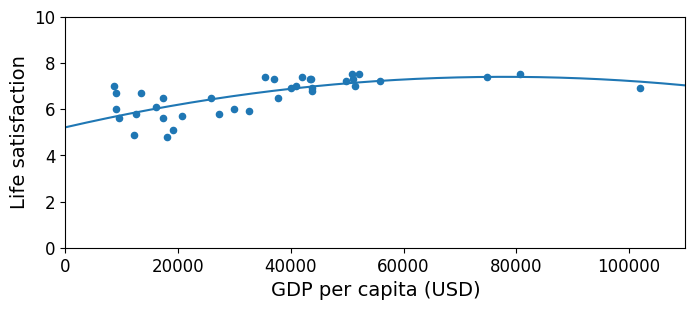

In [4]:
# Generamos un modelos polinomial utilizando: sklearn.preprocessing.PolynomialFeatures
# estandarizamos los datos mediante preprocessing.StandardScaler()
# Generamos un modelo utilizando LinearRegression().
# Probamos: polinomios de grados: 15, 10, 5, y 2. (en ese orden)
from sklearn import preprocessing
from sklearn import pipeline

full_country_stats.plot(kind='scatter',x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly',poly),('scal',scaler),('lin',lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:,np.newaxis])
plt.plot(X,curve)
plt.xlabel("GDP per capita (USD)")
plt.show()

Overfitting happens when the model is too complex relative to the amount and noisiness of the training data. The possible solutions are:

* To simplify the model by selecting one with fewer parameters (e.g., a linear model rather than a high-degree polinomial model), by reducing the number of attributes in the training data or by constraining the model.
* To gahter more training data
* To reduce the noise in the training data (e.g., fix data errors and remove outliers)

Constraining a model to make it simpler and reduce the risk of overfitting is called *regularization*. The amount of regularization to apply during learning can be controlled by a *hyperparameter*. A *hyperparameter* is a parameter of a learning algorithm (not of the model). As such, it is not affected by the learning algorithm itself; the learning algorihtm will almos certainly not overfit the training data, but it will be less likely to find a good solution. Tuning hyperparameters is an important part of building a Machine Learning system.

In [ ]:
# Se realiza lo siguiente:
# mostramos los datos originales y los datos faltantes en la misma gráfica en diferentes conjuntos (colores)
# Se generarán 3 modelos lineales: datos originales (parciales), datos completos y datos regularizados.
# se mostraŕan las rectas que definen esos modelos.
plt.xlabel("GDP per capita")
plt.ylabel("LIfe satisfaction")

plt.plot(list(sample_data["GDP per capita"]),list(sample_data["Life satisfaction"]),"bo")
plt.plot(list(missing_data["GDP per capita"]),list(missing_data["Life satisfaction"]),"rs")

X = np.linspace(0,110000,1000)
plt.plot(X,t0full + t1full * X,"r--",label="Linear model on all data")
plt.plot(X, t0+t1*X, "b:",label="Linear model on partial data")

ridge = linear_model.Ridge(alpha=10**9.5)
Xsample=np.c_[sample_data["GDP per capita"]]
ysample=np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample,ysample)
t0ridge,t1ridge=ridge.intercept_[0],ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge *X,"b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0,110000,0,10])
plt.show()

## Underfitting the training data

*Underfitting* is the opposite of overfitting; it ocurrs when your model is to simple to learn the underlying structure of the data.
The main options to fix this problem are:
* Selecting a more powerful model, with more parameters
* Feeding better features to the learning algorithm (feature engineering)
* Reducing the constraints on the model (e.g., reducing the regularization hyperparameter).

## Stepping back

* Machine Learning is about machines get better at some task by learning from data, instead of having to explicity code rules.
* There are many different types of ML systems: supervised or not, batch or online, instance-based or model-based, and so on.
* In a ML project you gather data in a training set, and you feed the training set to a learning algorithm. If the algorithm is model-based it tunes some parameters to fit the model to the training set (i.e., make good predictions on the training set itself), and then hopefully it will be able to make good predictions on new cases as well. If the algorithm is instance-based, it just learns the examples by heart and uses a similarity measure to generalize to new instances.
* The system will not perform well if your training set is too small, or if the data is not representative, noisy, or polluted with irrelevant features (garbage in, garbage out). Lastly, your model needs to be  neither too simple (in which case it will underfit) nor too complex (in which case it will overfit).

## Testing and Validating

The only way to know how well a model generalize to new cases is to actually try it out on new cases. The best option is to split your data into two sets: the *training set* and the *test set*.
The error rate on noew cases is called the *generalization error* (or *out-of-sample error*), and by evaluating your model on the test set, you get an estimation of this error.

> It is common to use 80% of the data for training and *hold out* 20% for testing.

A common solution to the problem where you measure the generalization error multiple times on the test set, is having a set called *validation set*.

To avoid "wasting" too much training data in validation set, a common technique is to use *cross-validation*: the training set is split into complementary subsets, and each model is trained against a different combination of these and validated against the remainin parts. One the model type and hyperparameters have been selected, a final model is trained using these hyperparameters on the full training set, and the generalized error is measured on the test set.